# Test the Model

In [1]:
import os
import json
import numpy as np
import pandas as pd
import torch
import cv2
from PIL import Image
from torchvision import transforms

from efficientnet_pytorch import EfficientNet

from utils import RoboflowHelper
from utils import calculate_bounding_box, crop_image

### Prepare

In [2]:
test_path = './testing'

json_path = os.path.join(test_path, 'whale_lookup.json')

with open(json_path, 'r') as json_file:
    argmax_dict = {np.array(value).argmax(): key for key, value in json.load(json_file).items()} 

argmax_dict

{0: 'whale_00195',
 1: 'whale_00442',
 2: 'whale_02411',
 3: 'whale_02608',
 4: 'whale_02839',
 5: 'whale_03103',
 6: 'whale_03227',
 7: 'whale_03623',
 8: 'whale_03728',
 9: 'whale_03935',
 10: 'whale_03990',
 11: 'whale_04373',
 12: 'whale_04397',
 13: 'whale_04435',
 14: 'whale_04480',
 15: 'whale_04540',
 16: 'whale_05140',
 17: 'whale_05349',
 18: 'whale_05487',
 19: 'whale_05661',
 20: 'whale_05784',
 21: 'whale_06069',
 22: 'whale_06334',
 23: 'whale_06339',
 24: 'whale_06967',
 25: 'whale_06997',
 26: 'whale_07331',
 27: 'whale_07483',
 28: 'whale_07647',
 29: 'whale_07808',
 30: 'whale_07863',
 31: 'whale_08017',
 32: 'whale_08181',
 33: 'whale_08324',
 34: 'whale_08439',
 35: 'whale_08637',
 36: 'whale_08700',
 37: 'whale_08729',
 38: 'whale_08923',
 39: 'whale_09062',
 40: 'whale_09181',
 41: 'whale_09422',
 42: 'whale_09454',
 43: 'whale_09651',
 44: 'whale_09913',
 45: 'whale_10005',
 46: 'whale_10021',
 47: 'whale_10583',
 48: 'whale_10977',
 49: 'whale_11076',
 50: 'whal

In [3]:
csv_path = os.path.join(test_path, 'test.csv')

# Reading the CSV file using Pandas
test_df = pd.read_csv(csv_path)
test_df.head()

,Image,whaleID
0,w_7754.jpg,whale_67036
1,w_5390.jpg,whale_23574
2,w_6695.jpg,whale_03227
3,w_7097.jpg,whale_80947
4,w_5859.jpg,whale_11242


In [4]:
model_path = os.path.join('model', 'WhaleEfficientNetB4.pt')

### Create Models

In [5]:
class WhaleEfficientNetB4(torch.nn.Module):
    def __init__(self, num_classes):
        super(WhaleEfficientNetB4, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b4')
        # Set output dimension to num_classes
        self.efficientnet._fc= torch.nn.Linear(
            in_features=self.efficientnet._fc.in_features,
            out_features=num_classes,
            bias=True)

    def forward(self, x):
        logits = self.efficientnet(x)
        return logits

class RightWhalePredictor():
    def __init__(self, model_path, lookup_dict):
        self.head_locator = RoboflowHelper()
        self.head_detector = WhaleEfficientNetB4(447)
        self.head_detector.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        self.head_detector.eval()
        self.transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor()
        ])
        self.lookup_dict = lookup_dict

    def predict_image(self, image_path):
        prediction = self.head_locator.get_prediction(image_path)
        if prediction:
            image = cv2.imread(image_path)
            start_point, end_point = calculate_bounding_box(prediction['x'], prediction['y'], prediction['width'], prediction['height'])
            cropped = Image.fromarray(crop_image(image, start_point, end_point))
            with torch.no_grad():
                image_tensors = torch.stack([self.transform(cropped)])
                output = self.head_detector(image_tensors)
                index = int(output.argmax(dim=1)[0])
                return self.lookup_dict[index]
        else:
            raise Exception("Prediction Failed")
    

In [6]:
right_whale_predictor = RightWhalePredictor(model_path, argmax_dict)

loading Roboflow workspace...
loading Roboflow project...
Loaded pretrained weights for efficientnet-b4


In [7]:
test_df.head()

,Image,whaleID
0,w_7754.jpg,whale_67036
1,w_5390.jpg,whale_23574
2,w_6695.jpg,whale_03227
3,w_7097.jpg,whale_80947
4,w_5859.jpg,whale_11242


In [8]:
right_whale_predictor.predict_image("./testing/w_7754.jpg")

'whale_67036'

## Testing

In [ ]:
y = list(test_df['whaleID'].values)

In [10]:
y_hat = []

for img in list(test_df['Image'].values):
    try:
        image_path = os.path.join(test_path, img)
        prediction = right_whale_predictor.predict_image(image_path)
        y_hat.append(prediction)
    except Exception:
        y_hat.append("")

In [11]:
y_hat

['whale_67036',
 'whale_86585',
 'whale_38894',
 'whale_38008',
 'whale_17528',
 'whale_85464',
 'whale_58309',
 'whale_48415',
 'whale_82554',
 'whale_06334',
 'whale_82554',
 '',
 'whale_54796',
 'whale_48490',
 'whale_37154',
 'whale_31739',
 'whale_24458',
 'whale_74232',
 'whale_11076',
 'whale_64006',
 'whale_02608',
 'whale_51195',
 'whale_55550',
 'whale_23847',
 '',
 'whale_48490',
 'whale_82387',
 'whale_66711',
 'whale_64937',
 'whale_64989',
 'whale_15519',
 'whale_98151',
 'whale_99326',
 'whale_21160',
 'whale_55079',
 'whale_47700',
 'whale_07647',
 'whale_52505',
 'whale_55079',
 'whale_84963',
 'whale_11625',
 '',
 'whale_05784',
 'whale_79166',
 'whale_73666',
 'whale_92686',
 'whale_53079',
 'whale_97542',
 'whale_44127',
 'whale_65586',
 '',
 'whale_48966',
 'whale_48497',
 'whale_82554',
 'whale_98746',
 'whale_67611',
 'whale_58747',
 'whale_63816',
 'whale_78372',
 'whale_74232',
 'whale_99573',
 'whale_11555',
 'whale_82554',
 'whale_97688',
 'whale_81875',
 'wh

In [25]:
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, f1_score

y_true = [y]
y_pred = [y_hat]
whale_ids = [["".join(re.findall("\w",f)) for f in lst] for lst in [s.split(",") for s in [i for i in argmax_dict.values()]]]


binarizer = MultiLabelBinarizer()
binarizer.fit(whale_ids)

f1 = f1_score(binarizer.transform(y_true), 
         binarizer.transform(y_pred), 
         average='micro')
accuracy = accuracy_score(y, y_hat)

print("Test Accuracy: {:.2f} % Test F1-Score: {:.4f}".format(accuracy * 100, f1))

Test Accuracy: 63.66 % Test F1-Score: 0.8512


unknown class(es) [''] will be ignored


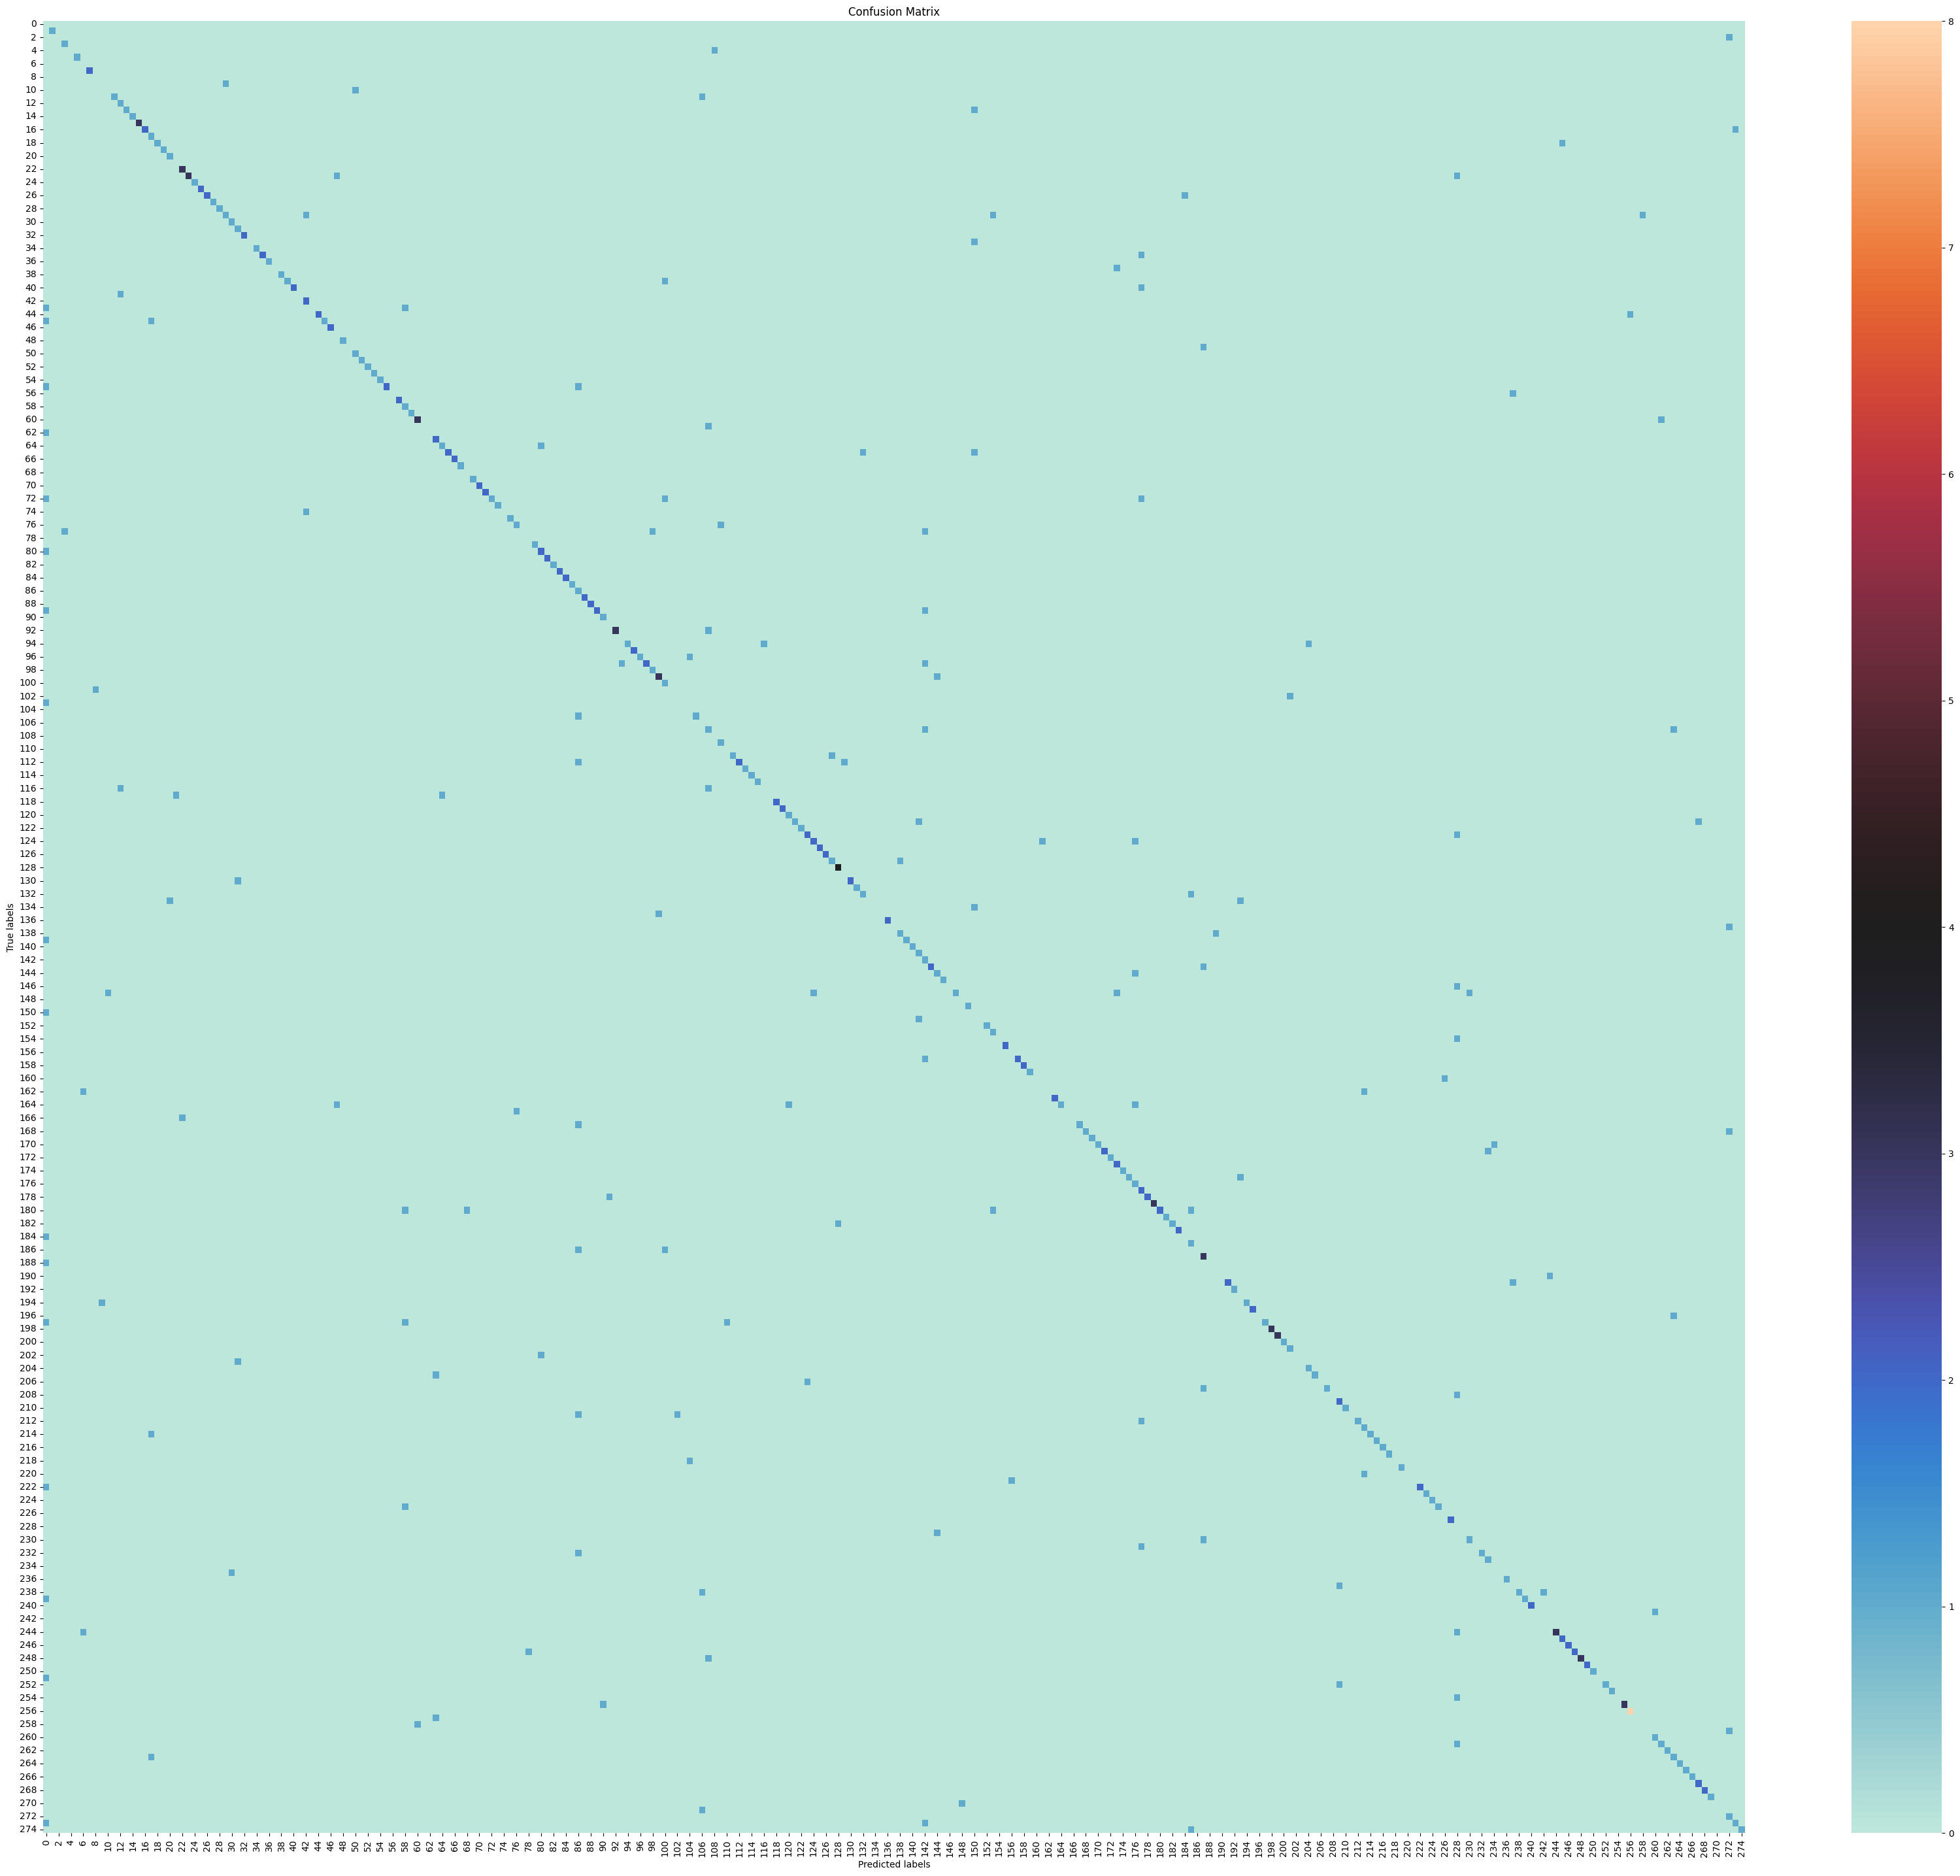

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
confusion_mat = confusion_matrix(y, y_hat)
plt.figure(figsize=(42, 36))
sns.heatmap(confusion_mat, cmap="icefire", linewidths=0.0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('./confusion_matrix.png')
plt.show()